# Modelling

In this notebook, a model will be designed to predict the price of a new rental offer based on its features. The objective is to have a RMSE lower (Root Mean Squared Error) than 300 which is a reasonable value given the small quantity of data. 

## 1. First Models

In this first step, several models are trained to compare their performances to select the most promising ones to meet the goal. The primary evaluation metric chosen is RMSE, which will be calculated for both the training and test sets. The models of particular interest are LinearRegression, RandomForestRegressor and GradientBoostingRegressor. 

> **Models**: <br><br> - LinearRegression <br> - LogisticRegression <br> - SupportVectorRegression <br> - RandomForestRegressor <br> - GradientBoostingRegressor <br> - KNeighborsRegressor <br>


> **Metrics**: <br><br> - R$^2$ <br> - Mean Squared Error <br> - **Root Mean Squared Error:** _Principal metric because it has the same dimension as the target variable (Price)_

> **Final results** (Most notable models): <br><br> - LinearRegression: _Decent performance in test (RMSE=499) despite its simplicity_ <br><br> - RandomForestRegresor: _Noteworthy performance in test (RMSE=460 // Best) and massive difference with training (RMSE=235) due to overfitting what might make it optimizable with hyperparameter tuning._ <br><br> - GradientBoostingRegressor: _Best perfomance in test **(RMSE=460)**_

## 2. Optimization

In this step, an optimization process is carried out to reach the target RMSE.  

### 2.1. Droping extreme values

AAfter reviewing the real values in the test set against the predictions from the Random Forest model, it became clear that **extreme values (over €2925) were consistently underestimated.** _(See plots for reference)_. These extreme values likely represent special cases where the price increase is driven by factors not captured in the dataset. 

**The approach was to drop many of these extreme values** to reduce artificial errors and avoid skewing the model. However, not all extreme values were removed to prevent eliminating too many observations and introducing underestimation near the threshold.

As a result of this optimization, the Gradient Boosting model's **RMSE improved, dropping from 460 to 358.**


### 2.2. Enriching dataset with new feature

Upon analyzing the most underestimated offers from the website where the data was scraped, a new feature idea emerged. Many of these offers were listed by the same real estate agency: Engel & Volkers. This information wasn't retrieved during the initial web scraping, so a **new scraping process** was conducted.

Next, an analysis of the agents' distribution was performed, comparing their average price per square meter _(See plot for reference)_. A distinct gap between two groups was identified, allowing the creation of a **new binary feature, 'Agent_cat', which could also be interpreted as distinguishing between premium and non-premium houses.**

Training the models with this new feature improved the performance significantly, **reducing the RMSE for the Gradient Boosting model to 305.**

### 2.3. Searching best hyperparameters

After the changes in 2.2, the Random Forest model showed an RMSE of 148 on the training set and 317 on the test set. This prompted an attempt to tune the hyperparameters to reduce overfitting and improve test performance. However, the results were insufficient to outperform the Gradient Boosting model, so the latter was chosen as the better model.




In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,PolynomialFeatures,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import ast

In [2]:
df=pd.read_csv('data.csv')


In [3]:
# Group locations with less than 5 offers in a new category: 'Other'
group_loc=pd.DataFrame(df['Location'].value_counts()).reset_index()
grouped_locations=list(group_loc.loc[group_loc['count']<5]['Location'].unique())
df['Location'].replace(grouped_locations,['Other' for i in range(len(grouped_locations))],inplace=True)
df['Location'].value_counts()

Location
Other                                   63
El Cabanyal-El Canyamelar               57
Russafa                                 48
Sant Francesc                           47
Arrancapins                             28
El Carme                                27
El Mercat                               25
Penya-roja                              20
La Malva-rosa                           18
El Pla del Remei                        18
Aiora                                   17
Gran Via                                17
Nou Moles                               17
La Punta                                16
La Seu                                  15
Ciutat Jardí                            15
La Petxina                              14
La Xerea                                13
La Roqueta                              13
El Grau                                 11
Ciutat de les Arts i de les Ciències    11
La Bega Baixa                           11
El Pilar                                10
Mo

## 1. First models
***

In [4]:
X=df.drop(['index','Price'],axis=1)
y=df.Price

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=77,stratify=X['Location'])

In [5]:
# Preprocessing to fit the models: Robust Scaler for continuous + One Hot Encoding for categorical
num=['Rooms','Bathrooms','Surface']
cat=['House_type','Location']

preprocessor= ColumnTransformer(transformers=[('num',RobustScaler(),num),
                                             ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),cat)],
                                remainder='passthrough' )


X_train_pre=preprocessor.fit_transform(X_train)
X_test_pre=preprocessor.transform(X_test)

In [6]:
# Models

lr=LinearRegression()

lor=LogisticRegression()

svrm=SVR(kernel='rbf')

rf=RandomForestRegressor()

gboost=GradientBoostingRegressor()

knn=KNeighborsRegressor()

models={'LinearRegression':lr,'LogisticRegression':lor,'SupportVectorRegression':svrm,
        'RandomForestRegression':rf,'GradientBoostingRegressor':gboost,'KNeighborsRegressor':knn}

In [7]:
# Function to train and calculate metrics for a model + saving them
def train_model(x):
    results['Model'].append(x[0])
    x[1].fit(X_train_pre,y_train)
    y_train_pred=x[1].predict(X_train_pre)
    y_test_pred=x[1].predict(X_test_pre)
    results['Train_R2'].append(round(x[1].score(X_train_pre,y_train),3))
    results['Test_R2'].append(round(x[1].score(X_test_pre,y_test),3))
    results['Train_MSE'].append(round(mean_squared_error(y_train,y_train_pred)))
    results['Test_MSE'].append(round(mean_squared_error(y_test,y_test_pred)))
    results['Train_RMSE'].append(round(np.sqrt(mean_squared_error(y_train,y_train_pred))))
    results['Test_RMSE'].append(round(np.sqrt(mean_squared_error(y_test,y_test_pred))))
    results['model_trained'].append(x[1])
    print(x[0],'OK')

    

In [8]:
results={'Model':[],'Train_R2':[],'Test_R2':[],'Train_MSE':[],'Test_MSE':[],'Train_RMSE':[],'Test_RMSE':[],'model_trained':[]}
for model in models.items():
    train_model(model)

LinearRegression OK
LogisticRegression OK
SupportVectorRegression OK


C:\Users\Guillermo\Documents\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestRegression OK
GradientBoostingRegressor OK
KNeighborsRegressor OK


In [9]:
#Results
pd.DataFrame(results)[list(results.keys())[:-1]]

,Model,Train_R2,Test_R2,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,LinearRegression,0.518,0.318,253915,248586,504,499
1,LogisticRegression,0.314,0.111,329475,295844,574,544
2,SupportVectorRegression,-0.033,-0.021,543544,372290,737,610
3,RandomForestRegression,0.895,0.418,55181,212056,235,460
4,GradientBoostingRegressor,0.728,0.419,143141,211607,378,460
5,KNeighborsRegressor,0.534,0.364,245136,231779,495,481


## 2. Optimization
***

### 2.1. Droping extreme values
***

In [10]:
rf2=results['model_trained'][3]
rf2

RandomForestRegressor()

In [11]:
y_test_pred=rf2.predict(X_test_pre)
y_train_pred=rf2.predict(X_train_pre)

predictions=pd.DataFrame({'index':list(y_test.index),'Real':list(y_test),'Prediction':y_test_pred})
predictions['Diff']=predictions['Prediction']-predictions['Real']

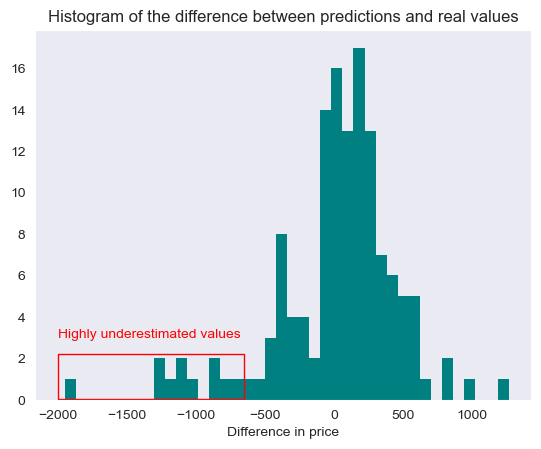

In [12]:
sns.set_style('dark')
plt.hist(predictions['Diff'],bins=40,color='teal',linewidth=0)
plt.title('Histogram of the difference between predictions and real values')
plt.plot([-2000,-2000,-650,-650,-2000],[0.05,2.2,2.2,0.05,0.05],linewidth=1,color='red')
plt.text(-2000,3,'Highly underestimated values',color='red')
plt.xlabel('Difference in price')
plt.savefig('./Images/histogram_extreme_values.png')
plt.show()

[]

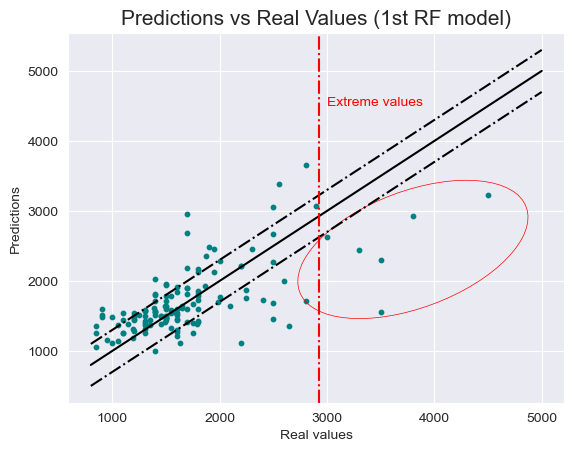

In [13]:
sns.set_style('darkgrid')

plt.scatter(predictions['Real'],predictions['Prediction'],s=10,color='teal')

plt.plot([800,5000],[800,5000],'k')
plt.plot([800,5000],[1100,5300],'-.k')
plt.plot([800,5000],[500,4700],'-.k')

plt.axvline(2925,color='red',linestyle='-.')
plt.text(3000,4500,'Extreme values',color='red')

plt.title('Predictions vs Real Values (1st RF model)',fontsize=15)
plt.xlabel('Real values')
plt.ylabel('Predictions')

ax = plt.gca()
ellipse = Ellipse(xy=(3800, 2450), width=2500, height=1500,
                  edgecolor='r', fc='None', lw=0.5, angle=40)
ax.add_patch(ellipse)
plt.savefig('./Images/predvsreal_extreme_values.png')
plt.plot()

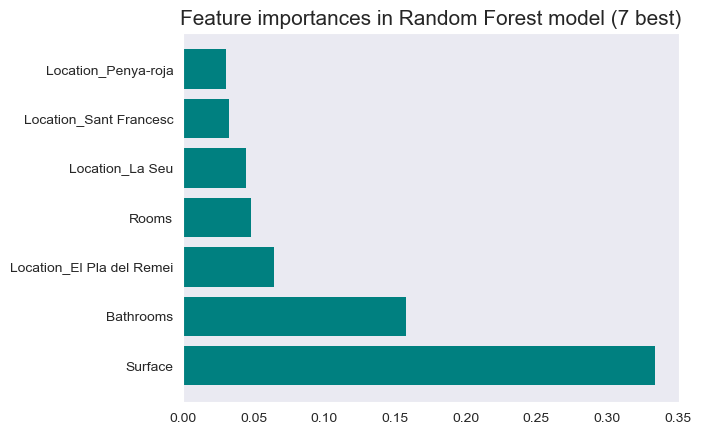

In [14]:
ohe = preprocessor.named_transformers_['cat']
cat_columns = ohe.get_feature_names_out(cat)
passthrough_columns = [col for col in X_train.columns if col not in num + cat]
all_columns = list(num) + list(cat_columns) + passthrough_columns

feature_importances=pd.DataFrame(list(zip(all_columns,rf2.feature_importances_)),columns=['Feature','Importance']).sort_values('Importance',ascending=False)

sns.set_style('dark')
plt.barh(feature_importances['Feature'][0:7],feature_importances['Importance'][0:7],color='teal',linewidth=0)
plt.title('Feature importances in Random Forest model (7 best)',fontsize=15)
plt.show()

In [15]:
df_without_extreme_values=df.drop(df.loc[df['Price']>3200].index)

In [16]:
X=df_without_extreme_values.drop(['index','Price'],axis=1)
y=df_without_extreme_values.Price

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=77,stratify=X['Location'])

X_train_pre=preprocessor.fit_transform(X_train)
X_test_pre=preprocessor.transform(X_test)

In [17]:
results={'Model':[],'Train_R2':[],'Test_R2':[],'Train_MSE':[],'Test_MSE':[],'Train_RMSE':[],'Test_RMSE':[],'model_trained':[]}
for model in models.items():
    train_model(model)
pd.DataFrame(results)[list(results.keys())[:-1]]

LinearRegression OK
LogisticRegression OK
SupportVectorRegression OK


C:\Users\Guillermo\Documents\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestRegression OK
GradientBoostingRegressor OK
KNeighborsRegressor OK


,Model,Train_R2,Test_R2,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,LinearRegression,0.471,0.389,122395,128974,350,359
1,LogisticRegression,0.298,0.085,166664,182948,408,428
2,SupportVectorRegression,-0.030,-0.035,238548,218467,488,467
3,RandomForestRegression,0.888,0.334,25986,140685,161,375
4,GradientBoostingRegressor,0.642,0.394,82820,127852,288,358
5,KNeighborsRegressor,0.556,0.295,102773,148806,321,386


In [18]:
rf2=results['model_trained'][3]
y_test_pred=rf2.predict(X_test_pre)
y_train_pred=rf2.predict(X_train_pre)

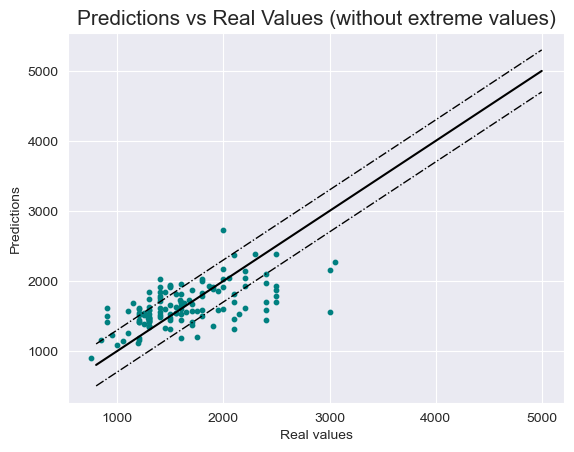

In [19]:
predictions=pd.DataFrame({'index':list(y_test.index),'Real':list(y_test),'Prediction':y_test_pred})
sns.set_style('darkgrid')
plt.scatter(predictions['Real'],predictions['Prediction'],s=10,color='teal')
plt.plot([800,5000],[800,5000],'k')
plt.plot([800,5000],[1100,5300],'-.k',linewidth=1)
plt.plot([800,5000],[500,4700],'-.k',linewidth=1)

plt.title('Predictions vs Real Values (without extreme values)',fontsize=15)
plt.xlabel('Real values')
plt.ylabel('Predictions')

plt.show()

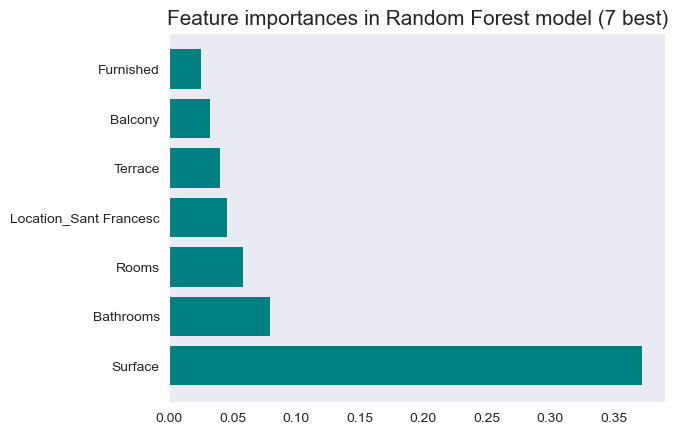

In [20]:
ohe = preprocessor.named_transformers_['cat']
cat_columns = ohe.get_feature_names_out(cat)
passthrough_columns = [col for col in X_train.columns if col not in num + cat]
all_columns = list(num) + list(cat_columns) + passthrough_columns

feature_importances=pd.DataFrame(list(zip(all_columns,rf2.feature_importances_)),columns=['Feature','Importance']).sort_values('Importance',ascending=False)

sns.set_style('dark')
plt.barh(feature_importances['Feature'][0:7],feature_importances['Importance'][0:7],color='teal',linewidth=0)
plt.title('Feature importances in Random Forest model (7 best)',fontsize=15)
plt.show()

### 2.2. Enriching dataset with new feature
***

In [21]:
df=pd.read_csv('data2.csv',index_col='index')
df.head()

,Agent,House_type,Location,Furnished,Elevator,Terrace,Balcony,Storage,Rooms,Bathrooms,Surface,Price
index,,,,,,,,,,,,
0,Alain Consultores Inmobiliarios,Piso,Gran Via,1,1,0,0,0,2,1,79,1600
1,R&B Conforthouse,Piso,Sant Antoni,0,1,0,0,0,4,2,125,1300
2,R&B Conforthouse,Piso,El Perellonet,0,1,1,0,0,3,1,80,1100
3,R&B Conforthouse,Piso,El Perellonet,0,1,0,1,0,3,2,96,1195
4,PRIMERA AVENIDA - GRUPO INMOBILIARIO,Piso,Sant Francesc,0,1,0,0,0,5,3,236,4200


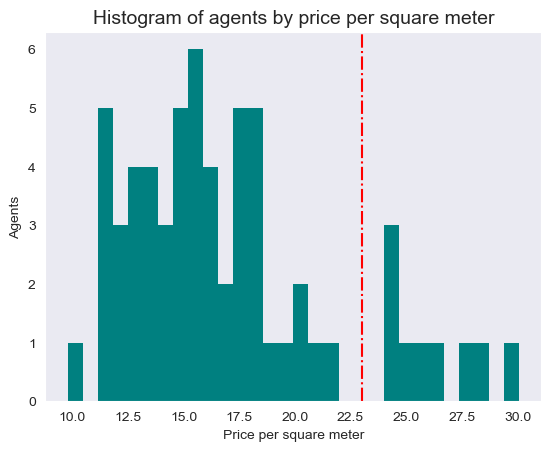

In [22]:
df['Ratio_price_surf']=df['Price']/df['Surface']
agents=pd.DataFrame(df.groupby('Agent').agg(Price=('Price','mean'),
                                       Ratio_price_surf=('Ratio_price_surf','mean'),
                                       n_offers=('Agent','count'),
                                       Surface=('Surface','mean'))).sort_values(by='Ratio_price_surf',ascending=False)
agents=agents.reset_index()
plt.hist(agents['Ratio_price_surf'],bins=30,color='teal',linewidth=0)
plt.axvline(23,color='red',linestyle='-.')

plt.title('Histogram of agents by price per square meter',fontsize=14)
plt.ylabel('Agents')
plt.xlabel('Price per square meter')

plt.savefig('./Images/histogram_agents.png')
plt.show()

In [23]:
agents.sort_values('Ratio_price_surf',ascending=False).head(10)

,Agent,Price,Ratio_price_surf,n_offers,Surface
0,Tecnopiso Catarroja,2750.000000,30.058480,2,92.500000
1,Expercasa Puerto de Sagunto,2330.000000,28.072289,1,83.000000
2,FINANCIS PERSONAL ADVISING,5500.000000,27.500000,1,200.000000
3,ROKSY HOME,1590.000000,26.500000,1,60.000000
4,Spotahome,1681.807692,25.739624,208,71.283654
5,VLC Invest,3250.000000,25.000000,2,135.000000
6,Desirée Hato Gestión De Inmuebles,1814.285714,24.445649,7,81.142857
7,Engel & Völkers Valencia,2124.122137,24.259168,131,95.007634
8,BIENES RAICES,1525.000000,24.171366,6,76.333333
9,Habitale Mestalla,1083.333333,21.296337,3,52.000000


In [24]:
agents_premium=list(agents.loc[agents['Ratio_price_surf']>23]['Agent'].unique())

def agents_cat(x):
    if x in agents_premium:
        return 1
    else:
        return 0
df['Agent_cat']=df['Agent'].apply(lambda x: agents_cat(x))
print(df['Agent_cat'].value_counts(dropna=False))
df.head()

Agent_cat
1    359
0    307
Name: count, dtype: int64


,Agent,House_type,Location,Furnished,Elevator,Terrace,Balcony,Storage,Rooms,Bathrooms,Surface,Price,Ratio_price_surf,Agent_cat
index,,,,,,,,,,,,,,
0,Alain Consultores Inmobiliarios,Piso,Gran Via,1,1,0,0,0,2,1,79,1600,20.253165,0
1,R&B Conforthouse,Piso,Sant Antoni,0,1,0,0,0,4,2,125,1300,10.400000,0
2,R&B Conforthouse,Piso,El Perellonet,0,1,1,0,0,3,1,80,1100,13.750000,0
3,R&B Conforthouse,Piso,El Perellonet,0,1,0,1,0,3,2,96,1195,12.447917,0
4,PRIMERA AVENIDA - GRUPO INMOBILIARIO,Piso,Sant Francesc,0,1,0,0,0,5,3,236,4200,17.796610,0


In [25]:
X=df.drop(['Price','Ratio_price_surf','Agent'],axis=1)
y=df.Price
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=77,stratify=X['Location'])

X_train_pre=preprocessor.fit_transform(X_train)
X_test_pre=preprocessor.transform(X_test)

In [26]:
results={'Model':[],'Train_R2':[],'Test_R2':[],'Train_MSE':[],'Test_MSE':[],'Train_RMSE':[],'Test_RMSE':[],'model_trained':[]}
for model in models.items():
    train_model(model)
pd.DataFrame(results)[list(results.keys())[:-1]]

LinearRegression OK
LogisticRegression OK


C:\Users\Guillermo\Documents\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SupportVectorRegression OK
RandomForestRegression OK
GradientBoostingRegressor OK
KNeighborsRegressor OK


,Model,Train_R2,Test_R2,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,LinearRegression,0.579,0.488,202854,407582,450,638
1,LogisticRegression,0.327,0.119,289856,486031,538,697
2,SupportVectorRegression,-0.033,-0.030,497614,819413,705,905
3,RandomForestRegression,0.904,0.425,46277,457590,215,676
4,GradientBoostingRegressor,0.754,0.372,118218,499927,344,707
5,KNeighborsRegressor,0.607,0.452,189276,436357,435,661


In [27]:
rf2=results['model_trained'][3]
y_test_pred=rf2.predict(X_test_pre)
y_train_pred=rf2.predict(X_train_pre)

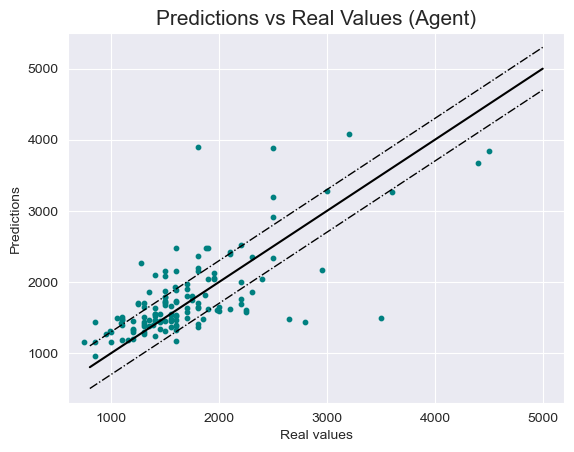

In [28]:
predictions=pd.DataFrame({'index':list(y_test.index),'Real':list(y_test),'Prediction':y_test_pred})
sns.set_style('darkgrid')
plt.scatter(predictions['Real'],predictions['Prediction'],s=10,color='teal')
plt.plot([800,5000],[800,5000],'k')
plt.plot([800,5000],[1100,5300],'-.k',linewidth=1)
plt.plot([800,5000],[500,4700],'-.k',linewidth=1)

plt.title('Predictions vs Real Values (Agent)',fontsize=15)
plt.xlabel('Real values')
plt.ylabel('Predictions')
plt.xlim(600,5200)
plt.ylim(300,5500)
plt.show()

In [29]:
df_without_extreme_values=df.drop(df.loc[df['Price']>3200].index)

X=df_without_extreme_values.drop(['Price','Ratio_price_surf','Agent','Ratio_price_surf'],axis=1)
y=df_without_extreme_values.Price
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=77,stratify=X['Location'])

X_train_pre=preprocessor.fit_transform(X_train)
X_test_pre=preprocessor.transform(X_test)

In [30]:
results={'Model':[],'Train_R2':[],'Test_R2':[],'Train_MSE':[],'Test_MSE':[],'Train_RMSE':[],'Test_RMSE':[],'model_trained':[]}
for model in models.items():
    train_model(model)
pd.DataFrame(results)[list(results.keys())[:-1]]

LinearRegression OK
LogisticRegression OK


C:\Users\Guillermo\Documents\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SupportVectorRegression OK
RandomForestRegression OK
GradientBoostingRegressor OK
KNeighborsRegressor OK


,Model,Train_R2,Test_R2,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
0,LinearRegression,0.577,0.375,102762,111124,321,333
1,LogisticRegression,0.311,0.134,166414,158849,408,399
2,SupportVectorRegression,-0.023,0.001,248843,177754,499,422
3,RandomForestRegression,0.910,0.434,21949,100617,148,317
4,GradientBoostingRegressor,0.690,0.478,75375,92908,275,305
5,KNeighborsRegressor,0.628,0.307,90518,123198,301,351


In [31]:
rf2=results['model_trained'][3]
y_test_pred=rf2.predict(X_test_pre)
y_train_pred=rf2.predict(X_train_pre)

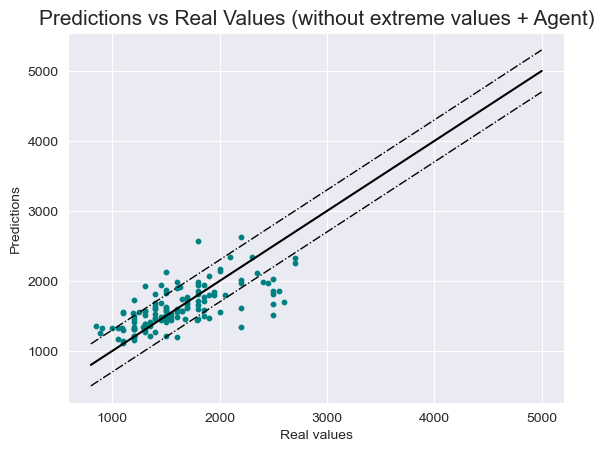

In [32]:
predictions=pd.DataFrame({'index':list(y_test.index),'Real':list(y_test),'Prediction':y_test_pred})
sns.set_style('darkgrid')
plt.scatter(predictions['Real'],predictions['Prediction'],s=10,color='teal')
plt.plot([800,5000],[800,5000],'k')
plt.plot([800,5000],[1100,5300],'-.k',linewidth=1)
plt.plot([800,5000],[500,4700],'-.k',linewidth=1)

plt.title('Predictions vs Real Values (without extreme values + Agent)',fontsize=15)
plt.xlabel('Real values')
plt.ylabel('Predictions')

plt.show()

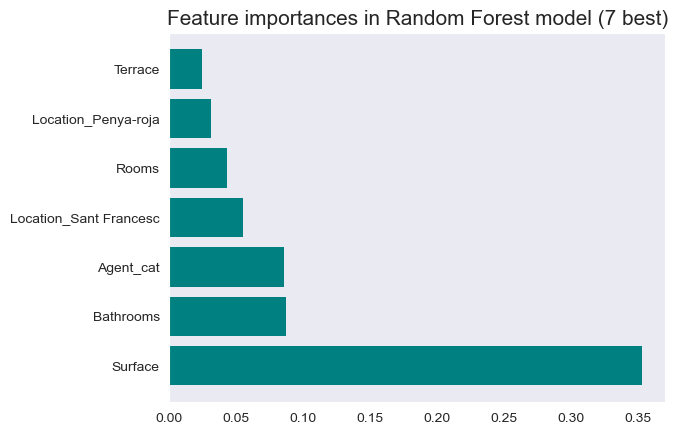

In [33]:
ohe = preprocessor.named_transformers_['cat']
cat_columns = ohe.get_feature_names_out(cat)
passthrough_columns = [col for col in X_train.columns if col not in num + cat]
all_columns = list(num) + list(cat_columns) + passthrough_columns

feature_importances=pd.DataFrame(list(zip(all_columns,rf2.feature_importances_)),columns=['Feature','Importance']).sort_values('Importance',ascending=False)

sns.set_style('dark')
plt.barh(feature_importances['Feature'][0:7],feature_importances['Importance'][0:7],color='teal',linewidth=0)
plt.title('Feature importances in Random Forest model (7 best)',fontsize=15)
plt.show()

### 2.3. Searching best hyperparameters
***

In [34]:
rf3=RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(rf3, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X_train_pre, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [35]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [36]:
rf4=grid_search.best_estimator_
y_test_pred=rf4.predict(X_test_pre)
y_train_pred=rf4.predict(X_train_pre)
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))
print(np.sqrt(mean_squared_error(y_train,y_train_pred)))

306.3659332202196
249.76558741023885


In [37]:
import joblib
best_model=results['model_trained'][4]
joblib.dump(best_model,'Rental_project_model.pkl')

['Rental_project_model.pkl']